In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

DIR = 'data'

In [2]:
# Reading names
words = open(f'{DIR}/names.txt').read().splitlines()
words[:5]

['ieretha', 'bruni', 'bran', 'rachoisa', 'marry']

In [3]:
symbols = sorted(list(set(''.join(words))))
num_of_symbols = 1 + len(symbols)   # adding '.' to the vocab
print(symbols)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y']


In [4]:
stoi = {ch: i + 1 for i, ch in enumerate(symbols)}
stoi['.'] = 0

itos = {i: ch for ch, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'y', 0: '.'}


### Building dataset
_block_size_: context length (how many previous characters are considered in the prediction) 

_X_: neural net inputs 

_Y_: neural net input labels

In [5]:
block_size = 3
X, Y = [], []

In [6]:
for name in words:
    context = [0] * block_size
    for ch in name + '.':
        idx = stoi[ch]
        X.append(context)
        Y.append(idx)

        # context update
        context = context[1:] + [idx] 

X, Y = torch.tensor(X), torch.tensor(Y)

### Parameters

In [40]:
# Hyperparameters
emb_dimensions = 2
num_of_neurons = 200 
hl_input_length = block_size * emb_dimensions

minibatch_size = 32
num_of_epochs = 10000
lr = 0.1

## NN parameters
C = torch.randn((num_of_symbols, emb_dimensions))
W1 = torch.randn((hl_input_length, num_of_neurons)) 
b1 = torch.randn(num_of_neurons)
W2 = torch.randn((num_of_neurons, num_of_symbols))
b2 = torch.randn(num_of_symbols)

In [41]:
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

### Model Training

In [33]:
lre = torch.linspace(-3, 0, num_of_epochs)
lrs = 10**lre

In [43]:
# Once the learning rates were evaluated, we choose a good one
lr = 10**-0.9

In [42]:
losses = []

In [44]:
# Stochastic Gradient Descent
for i in range(num_of_epochs):
    idx = torch.randint(0, X.shape[0], (minibatch_size,))

    """ Forward pass """
    emb = C[X[idx]]
    h = torch.tanh(emb.view(-1, hl_input_length) @ W1 + b1) # hidden layer
    logits = h @ W2 + b2                                    # output layer
    loss = F.cross_entropy(logits, Y[idx])                       # loss
    losses.append(loss.item())

    print(f"epoch {i}, {loss=}")

    """ Backward pass """
    for p in parameters:
        p.grad = None
    loss.backward()

    """ Update """
    for p in parameters:
        p.data += -lr * p.grad

epoch 0, loss=tensor(24.4473, grad_fn=<NllLossBackward0>)
epoch 1, loss=tensor(19.7221, grad_fn=<NllLossBackward0>)
epoch 2, loss=tensor(16.2201, grad_fn=<NllLossBackward0>)
epoch 3, loss=tensor(17.1371, grad_fn=<NllLossBackward0>)
epoch 4, loss=tensor(15.6395, grad_fn=<NllLossBackward0>)
epoch 5, loss=tensor(13.1863, grad_fn=<NllLossBackward0>)
epoch 6, loss=tensor(14.3549, grad_fn=<NllLossBackward0>)
epoch 7, loss=tensor(12.5963, grad_fn=<NllLossBackward0>)
epoch 8, loss=tensor(12.1532, grad_fn=<NllLossBackward0>)
epoch 9, loss=tensor(9.3145, grad_fn=<NllLossBackward0>)
epoch 10, loss=tensor(9.8055, grad_fn=<NllLossBackward0>)
epoch 11, loss=tensor(10.3581, grad_fn=<NllLossBackward0>)
epoch 12, loss=tensor(8.9500, grad_fn=<NllLossBackward0>)
epoch 13, loss=tensor(7.0508, grad_fn=<NllLossBackward0>)
epoch 14, loss=tensor(10.2322, grad_fn=<NllLossBackward0>)
epoch 15, loss=tensor(6.7021, grad_fn=<NllLossBackward0>)
epoch 16, loss=tensor(9.9486, grad_fn=<NllLossBackward0>)
epoch 17, los

### Searching for a good learning rate
Based on the first 1000 epochs, the learning rates used generated the following losses

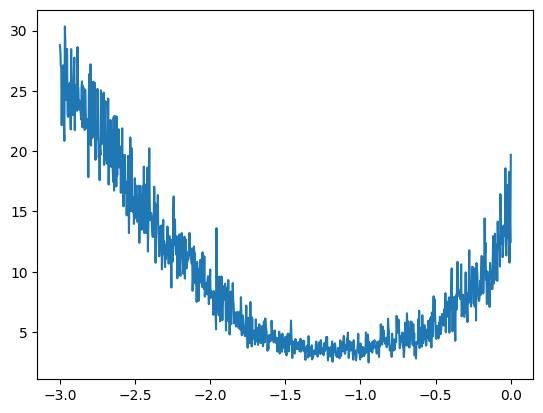

In [38]:
plt.plot(lre, losses)

We can see that around $lr=-0.9$, the loss was at its lowest. Therefore, that value will be used for the training

### Loss curve

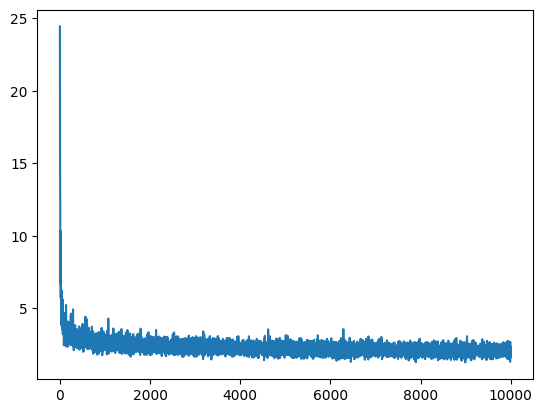

In [45]:
plt.plot(torch.arange(0, num_of_epochs), losses)